## 1. Import libraries and load the data

In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import rcParams
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn import metrics
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flight-fare-prediction-mh/Sample_submission.xlsx
/kaggle/input/flight-fare-prediction-mh/Data_Train.xlsx
/kaggle/input/flight-fare-prediction-mh/Test_set.xlsx


In [2]:
train_df=pd.read_excel('../input/flight-fare-prediction-mh/Data_Train.xlsx')
test_df= pd.read_excel('../input/flight-fare-prediction-mh/Test_set.xlsx')
train_df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
test_df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [4]:
print('Train Data shape:', train_df.shape)
print('Test Data shape:',test_df.shape)

Train Data shape: (10683, 11)
Test Data shape: (2671, 10)


## 2. EDA and Feature engineering

In [5]:
print(train_df.isnull().sum()), print(test_df.isnull().sum())

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64
Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64


(None, None)

In [6]:
# We see that in the training data the columns route and Total stops have a null value.
# So we remove the corresponding row.
train_df=train_df.dropna()
train_df.shape

(10682, 11)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10682 non-null  object
 1   Date_of_Journey  10682 non-null  object
 2   Source           10682 non-null  object
 3   Destination      10682 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10682 non-null  object
 6   Arrival_Time     10682 non-null  object
 7   Duration         10682 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10682 non-null  object
 10  Price            10682 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 1001.4+ KB


In [8]:
# We see that date of journey is of object type. So we need to convert it to datetime.
train_df['Journey_day']= pd.to_datetime(train_df['Date_of_Journey'], format='%d/%m/%Y').dt.day
train_df['Journey_month']= pd.to_datetime(train_df['Date_of_Journey'], format='%d/%m/%Y').dt.month
train_df['Weekday']= pd.to_datetime(train_df['Date_of_Journey'], format='%d/%m/%Y').dt.weekday

test_df['Journey_day']= pd.to_datetime(test_df['Date_of_Journey'], format='%d/%m/%Y').dt.day
test_df['Journey_month']= pd.to_datetime(test_df['Date_of_Journey'], format='%d/%m/%Y').dt.month
test_df['Weekday']= pd.to_datetime(test_df['Date_of_Journey'], format='%d/%m/%Y').dt.weekday

In [9]:
# Now that we have extracted necessary info from date of journey column, we can remove that column
train_df.drop(['Date_of_Journey'], axis=1, inplace=True)

In [10]:
test_df.drop(['Date_of_Journey'], axis=1, inplace=True)

In [11]:
train_df.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Weekday
0,IndiGo,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,24,3,6
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,1,5,2
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,9,6,6
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,12,5,6
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,1,3,4


In [12]:
# Notice the duration is in hours and min. We convert it to minutes.

def duration(minutes):
    minutes=minutes.strip()
    total=minutes.split(' ')
    to=total[0]
    hours=int(to[:-1])*60# -1 because last character is h
    if((len(total))==2):
        mins=(int)(total[1][:-1])# -1 because last character is m
        hours=hours+mins
    minutes=str(hours)
    return minutes
train_df['Duration']=train_df['Duration'].apply(duration)
test_df['Duration']=test_df['Duration'].apply(duration)

In [13]:
# Departure and arrival times in themselves are not necessarily high weighted features.
# So from this we extract the time of day which will serve as an important factor.
def departtime(x):
    x=x.strip()
    tt=(int)(x.split(':')[0])
    if(tt>=16 and tt<21):
        x='Evening'
    elif(tt>=21 or tt<5):
        x='Night'
    elif(tt>=5 and tt<11):
        x='Morning'
    elif(tt>=11 and tt<16):
        x='Afternoon'
    return x
train_df['Dep_Time']=train_df['Dep_Time'].apply(departtime)
test_df['Dep_Time']=test_df['Dep_Time'].apply(departtime)
train_df['Arrival_Time']=train_df['Arrival_Time'].apply(departtime)
test_df['Arrival_Time']=test_df['Arrival_Time'].apply(departtime)

In [14]:
# Converting the categorical value of total stops to 0,1,2....
train_df['Total_Stops'].value_counts()
train_df.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

In [15]:
# Now that we have total stops we don't need the route column.
train_df.drop(['Route'], axis=1, inplace=True)
test_df.drop(['Route'], axis=1, inplace=True)

In [16]:
train_df['Additional_Info'].value_counts()

No info                         8344
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
2 Long layover                     1
Red-eye flight                     1
1 Short layover                    1
Name: Additional_Info, dtype: int64

In [17]:
# We see that no info fills up most of the values for this column. So its better to drop this column.
train_df.drop(['Additional_Info'], axis=1, inplace=True)

In [18]:
train_df.head()

,Airline,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Price,Journey_day,Journey_month,Weekday
0,IndiGo,Banglore,New Delhi,Night,Night,170,0,3897,24,3,6
1,Air India,Kolkata,Banglore,Morning,Afternoon,445,2,7662,1,5,2
2,Jet Airways,Delhi,Cochin,Morning,Night,1140,2,13882,9,6,6
3,IndiGo,Kolkata,Banglore,Evening,Night,325,1,6218,12,5,6
4,IndiGo,Banglore,New Delhi,Evening,Night,285,1,13302,1,3,4


## 3. Data visualization

In [19]:
sns.set_style('darkgrid')
rcParams['figure.figsize']=12,5

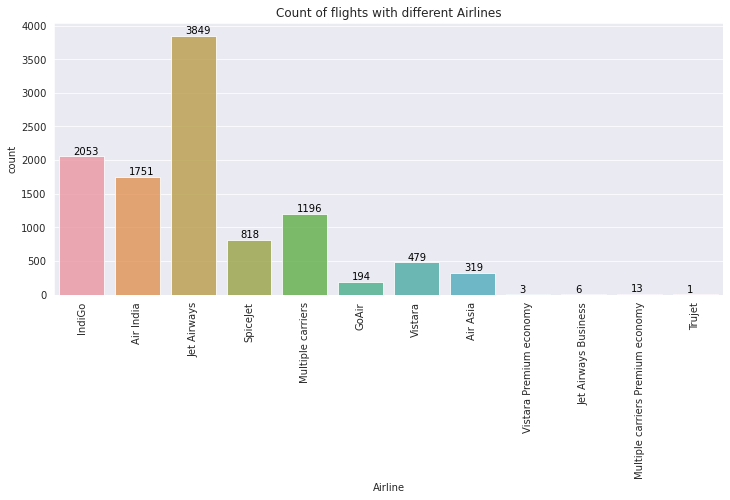

In [20]:
plt.title('Count of flights with different Airlines')
airline_freq=sns.countplot(x='Airline', data=train_df, alpha=0.8)
airline_freq.set_xticklabels(airline_freq.get_xticklabels(), rotation=90)
for p in airline_freq.patches:
    airline_freq.annotate(int(p.get_height()), (p.get_x()+0.25, p.get_height()+1), va='bottom',
                    color= 'black')

From the above plots we can see that vistara, jet airways business and multiple carriers
have very few flights. A way to resolve this would be to combine the 4 airlines, namely- Multiple carriers Premium economy, Jet Airways Business, Vistara Premium economy, Trujet, into a single airline and name it others. But i am not doing that because many people might prefer some of these airlines. They might prefer Vistara becauseof its ambience or some other thing.

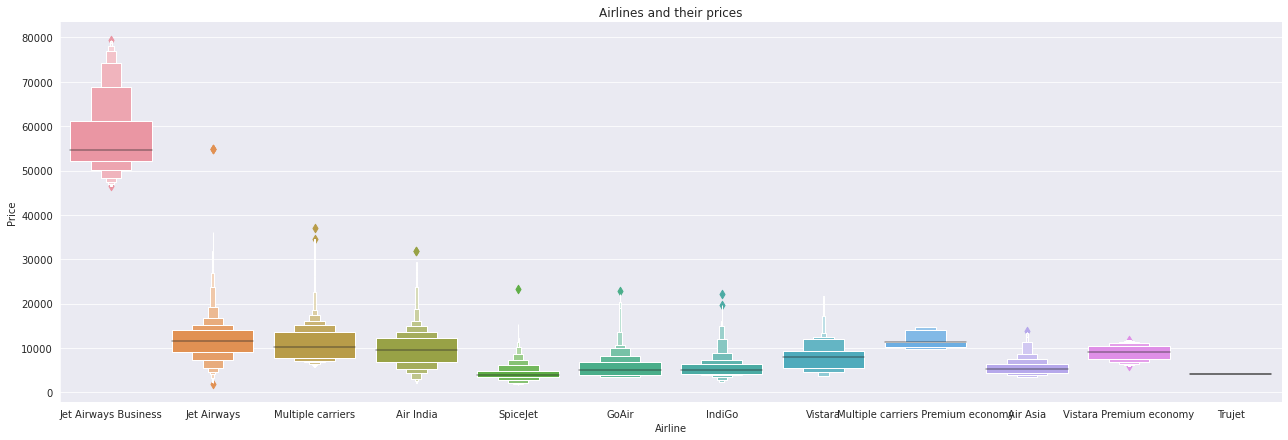

In [21]:
# Now lets see the prices of various airlines
sns.catplot(y = "Price", x = "Airline", data = train_df.sort_values("Price", ascending = False), 
            kind="boxen", height = 6, aspect = 3)
plt.title('Airlines and their prices')
plt.show()
# We can see that jet airways business has the highest prices and the prices of other airlines are almost similar.

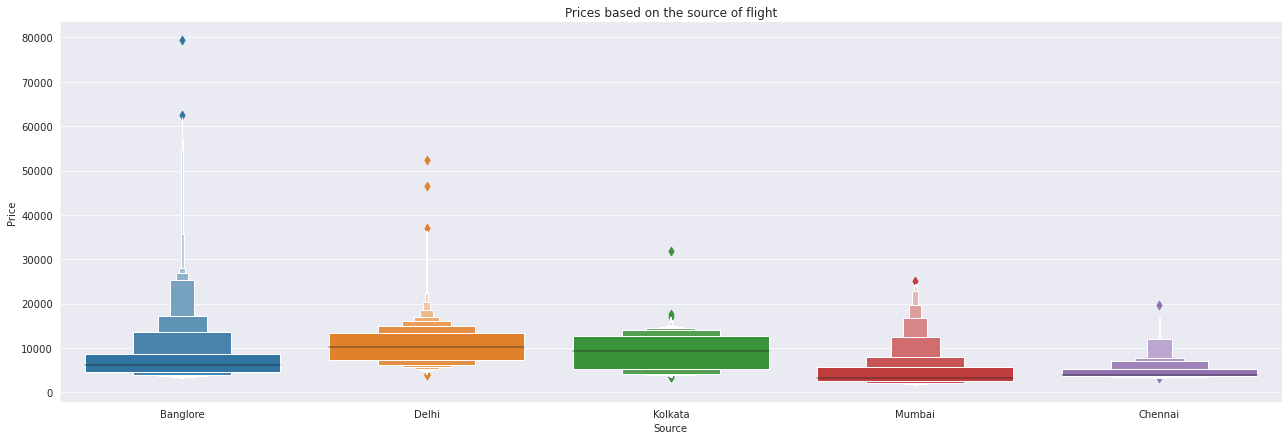

In [22]:
# Let's now visualize the prices of airlines based on their sources
sns.catplot(y='Price',x='Source',data= train_df.sort_values('Price',ascending=False),
            kind="boxen",height=6, aspect=3)
plt.title('Prices based on the source of flight')
plt.show()

## 4. Encoding categorical features and more preprocessing

In [23]:
train_df.head()

,Airline,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Price,Journey_day,Journey_month,Weekday
0,IndiGo,Banglore,New Delhi,Night,Night,170,0,3897,24,3,6
1,Air India,Kolkata,Banglore,Morning,Afternoon,445,2,7662,1,5,2
2,Jet Airways,Delhi,Cochin,Morning,Night,1140,2,13882,9,6,6
3,IndiGo,Kolkata,Banglore,Evening,Night,325,1,6218,12,5,6
4,IndiGo,Banglore,New Delhi,Evening,Night,285,1,13302,1,3,4


In [24]:
# One hot encoding these features
airline_oh=pd.get_dummies(train_df['Airline'], drop_first=True)
source_oh=pd.get_dummies(train_df['Source'], drop_first=True)
destination_oh=pd.get_dummies(train_df['Destination'], drop_first=True)

In [25]:
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
train_df['Dep_Time']=label_encoder.fit_transform(train_df['Dep_Time'])
train_df['Arrival_Time']=label_encoder.fit_transform(train_df['Arrival_Time'])

In [26]:
final_train_df=pd.concat([train_df, airline_oh, source_oh, destination_oh], axis=1)

In [27]:
final_train_df.drop(["Airline", "Source", "Destination"], axis = 1, inplace = True)

In [28]:
final_train_df.head()

,Dep_Time,Arrival_Time,Duration,Total_Stops,Price,Journey_day,Journey_month,Weekday,Air India,GoAir,...,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,3,3,170,0,3897,24,3,6,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,0,445,2,7662,1,5,2,1,0,...,0,0,0,1,0,0,0,0,0,0
2,2,3,1140,2,13882,9,6,6,0,0,...,0,0,1,0,0,1,0,0,0,0
3,1,3,325,1,6218,12,5,6,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,3,285,1,13302,1,3,4,0,0,...,0,0,0,0,0,0,0,0,0,1


In [29]:
final_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Dep_Time                           10682 non-null  int64 
 1   Arrival_Time                       10682 non-null  int64 
 2   Duration                           10682 non-null  object
 3   Total_Stops                        10682 non-null  int64 
 4   Price                              10682 non-null  int64 
 5   Journey_day                        10682 non-null  int64 
 6   Journey_month                      10682 non-null  int64 
 7   Weekday                            10682 non-null  int64 
 8   Air India                          10682 non-null  uint8 
 9   GoAir                              10682 non-null  uint8 
 10  IndiGo                             10682 non-null  uint8 
 11  Jet Airways                        10682 non-null  uint8 
 12  Jet 

In [30]:
# We see that many columns have become int type due to label encoding.
# So we will convert them into proper data type.
final_train_df["Weekday"] = final_train_df["Weekday"].astype(object)
final_train_df["Dep_Time"] = final_train_df["Dep_Time"].astype(object)
final_train_df["Arrival_Time"]=final_train_df["Arrival_Time"].astype(object)
final_train_df["Total_Stops"]=final_train_df["Total_Stops"].astype(object)
final_train_df["Journey_day"]=final_train_df["Journey_day"].astype(object)
final_train_df["Journey_month"]=final_train_df["Journey_month"].astype(object)
final_train_df["Duration"]=final_train_df["Duration"].astype(int)

In [31]:
final_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 28 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Dep_Time                           10682 non-null  object
 1   Arrival_Time                       10682 non-null  object
 2   Duration                           10682 non-null  int64 
 3   Total_Stops                        10682 non-null  object
 4   Price                              10682 non-null  int64 
 5   Journey_day                        10682 non-null  object
 6   Journey_month                      10682 non-null  object
 7   Weekday                            10682 non-null  object
 8   Air India                          10682 non-null  uint8 
 9   GoAir                              10682 non-null  uint8 
 10  IndiGo                             10682 non-null  uint8 
 11  Jet Airways                        10682 non-null  uint8 
 12  Jet 

In [32]:
# Standardizing the duration
final_train_df['Duration']=(final_train_df['Duration']-final_train_df['Duration'].mean())/final_train_df['Duration'].std()

In [33]:
final_train_df.head()

,Dep_Time,Arrival_Time,Duration,Total_Stops,Price,Journey_day,Journey_month,Weekday,Air India,GoAir,...,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,3,3,-0.931558,0,3897,24,3,6,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,0,-0.390009,2,7662,1,5,2,1,0,...,0,0,0,1,0,0,0,0,0,0
2,2,3,0.978630,2,13882,9,6,6,0,0,...,0,0,1,0,0,1,0,0,0,0
3,1,3,-0.626321,1,6218,12,5,6,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,3,-0.705092,1,13302,1,3,4,0,0,...,0,0,0,0,0,0,0,0,0,1


In [34]:
X=final_train_df.drop(['Price'], axis=1)
Y=final_train_df['Price']

In [35]:
X.head()

,Dep_Time,Arrival_Time,Duration,Total_Stops,Journey_day,Journey_month,Weekday,Air India,GoAir,IndiGo,...,Vistara Premium economy,Chennai,Delhi,Kolkata,Mumbai,Cochin,Delhi,Hyderabad,Kolkata,New Delhi
0,3,3,-0.931558,0,24,3,6,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,2,0,-0.390009,2,1,5,2,1,0,0,...,0,0,0,1,0,0,0,0,0,0
2,2,3,0.978630,2,9,6,6,0,0,0,...,0,0,1,0,0,1,0,0,0,0
3,1,3,-0.626321,1,12,5,6,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,1,3,-0.705092,1,1,3,4,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [36]:
Y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

## 5. Model training and evaluation

<p>Stratified k-fold was tried but didn't result in much better prediction and was thus dropped. Lasso and ridge regression was also tried and resulted in poor result.<br>Initially random forest was tried and manually tuned.<br>Ultimately grid search and randomized search with cross validation was used to tune the hyperparameters of 2 models:
<ol>
    <li>random forest regressor</li>
    <li>gradient boosting regressor</li>
</ol>
But randomized search was taking a lot of time to run and manually tuning and experimenting on random forest's hyperparameters took less time and i landed on a good set of hyperparameters which resulted in the best accuracy out of all.
</p>

In [37]:
x_train, x_test, y_train, y_test=train_test_split(X, Y, test_size=0.2)
print(f'x_train shape:{x_train.shape} x_test shape:{x_test.shape}')
print(f'y_train shape:{y_train.shape} y_test shape:{y_test.shape}')

x_train shape:(8545, 27) x_test shape:(2137, 27)
y_train shape:(8545,) y_test shape:(2137,)


In [152]:
rf= RandomForestRegressor(n_estimators=200, max_depth=20, 
                          min_samples_split=12, min_samples_leaf=2)
rf.fit(x_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=12,
                      n_estimators=200)

In [153]:
y_pred = rf.predict(x_test)

In [154]:
print('Training set score:', rf.score(x_train, y_train))
print('Test set score:', rf.score(x_test, y_test))

Training set score: 0.8857087243209663
Test set score: 0.8200298506919873


In [42]:
rfreg=RandomForestRegressor()
gbm=GradientBoostingRegressor()

In [160]:
rf_params={'n_estimators': [200, 300], 'min_samples_split': [4, 7, 11], 
           'min_samples_leaf': [1, 2, 4], "max_features" : ["auto", "log2", "sqrt"], 
           'bootstrap':[True, False]}
best_rfreg= RandomizedSearchCV(rfreg, rf_params, n_iter=10, cv=4, n_jobs=-1, verbose=1)
best_rfreg.fit(X, Y)
rfreg_score=cross_val_score(best_rfreg, X, Y, cv=4)
print("Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(rfreg_score), np.std(rfreg_score)*2))

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.3min finished


Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.1min finished


Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.3min finished


Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.5min finished


Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  2.0min finished


Cross validation score: 79.42% (+/- 4.08%)


In [59]:
gbm_params={'learning_rate':[0.01,0.05,0.1],'max_depth':[1,2,3],
            'n_estimators':[100,200,500]}
best_gbm= GridSearchCV(gbm, gbm_params, cv=5, n_jobs=-1)
best_gbm.fit(X, Y)
gbm_score = cross_val_score(best_gbm.best_estimator_, X, Y, cv=5)
print("GBM Cross validation score: {0:.2%} (+/- {1:.2%})".format(np.mean(gbm_score), np.std(gbm_score)*2))

GBM Cross validation score: 80.95% (+/- 2.95%)


## Saving the model for reuse

In [155]:
import pickle
# open a file, where you ant to store the data
file = open('flight_preds.pkl', 'wb')

# dump information to that file
pickle.dump(rf, file)

In [156]:
model = open('flight_preds.pkl','rb')
forest = pickle.load(model)

In [159]:
y_prediction = forest.predict(x_test)
metrics.r2_score(y_test, y_prediction)

0.8200298506919873